In [8]:
# 1. IMPORTS - KEEP NOTEBOOK CLEAN
# ====================================================

import sys
sys.path.append('../src')

from bayesian_model import BayesianChangePointModel
from change_point_analyzer import ChangePointAnalyzer
from visualization import Task2Visualizer
from change_point_fast import FastBayesianCPD, analyze_brent_oil

import pymc as pm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ Modules loaded successfully")

✅ Modules loaded successfully


In [9]:
# 2. LOAD DATA FROM TASK 1
# ====================================================

print("📊 Loading preprocessed data from Task 1...")

price_df = pd.read_csv('../data/raw/BrentOilPrices.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])

events_df = pd.read_csv('../data/raw/events_1987_2022.csv')
events_df['Start_Date'] = pd.to_datetime(events_df['Start_Date'])

print(f"✅ Price data: {len(price_df):,} records")
print(f"✅ Event data: {len(events_df)} events")
print(f"📅 {price_df['Date'].dt.year.min()}-{price_df['Date'].dt.year.max()}")

📊 Loading preprocessed data from Task 1...
✅ Price data: 9,011 records
✅ Event data: 17 events
📅 1987-2022


In [ ]:
plot_price_with_multiple_changepoints(
    prices_df,
    tau_true_list,
    tau_labels=[f'True CP {i+1}' for i in range(len(tau_true_list))],
    output_path=f'../outputs/multiple_01_true_changepoints_{n_changepoints}cp.png',
    title=f'Price Time Series with {n_changepoints} True Change Points'
)

In [10]:
# 3. DATA PREPARATION FOR BAYESIAN MODELING
# ====================================================

print("\n📈 Preparing data for change point analysis...")

# Calculate log returns (stationary series for modeling)
price_df['Log_Returns'] = np.log(price_df['Price']).diff()
price_df['Returns'] = price_df['Price'].pct_change()

print(f"✅ Calculated returns and log returns")
print(f"📊 Returns mean: {price_df['Returns'].mean()*100:.2f}%")
print(f"📊 Returns volatility: {price_df['Returns'].std()*100:.2f}%")
print(f"📊 Log returns mean: {price_df['Log_Returns'].mean()*100:.4f}%")


📈 Preparing data for change point analysis...
✅ Calculated returns and log returns
📊 Returns mean: 0.05%
📊 Returns volatility: 2.53%
📊 Log returns mean: 0.0179%



🎨 Visualizing data characteristics...


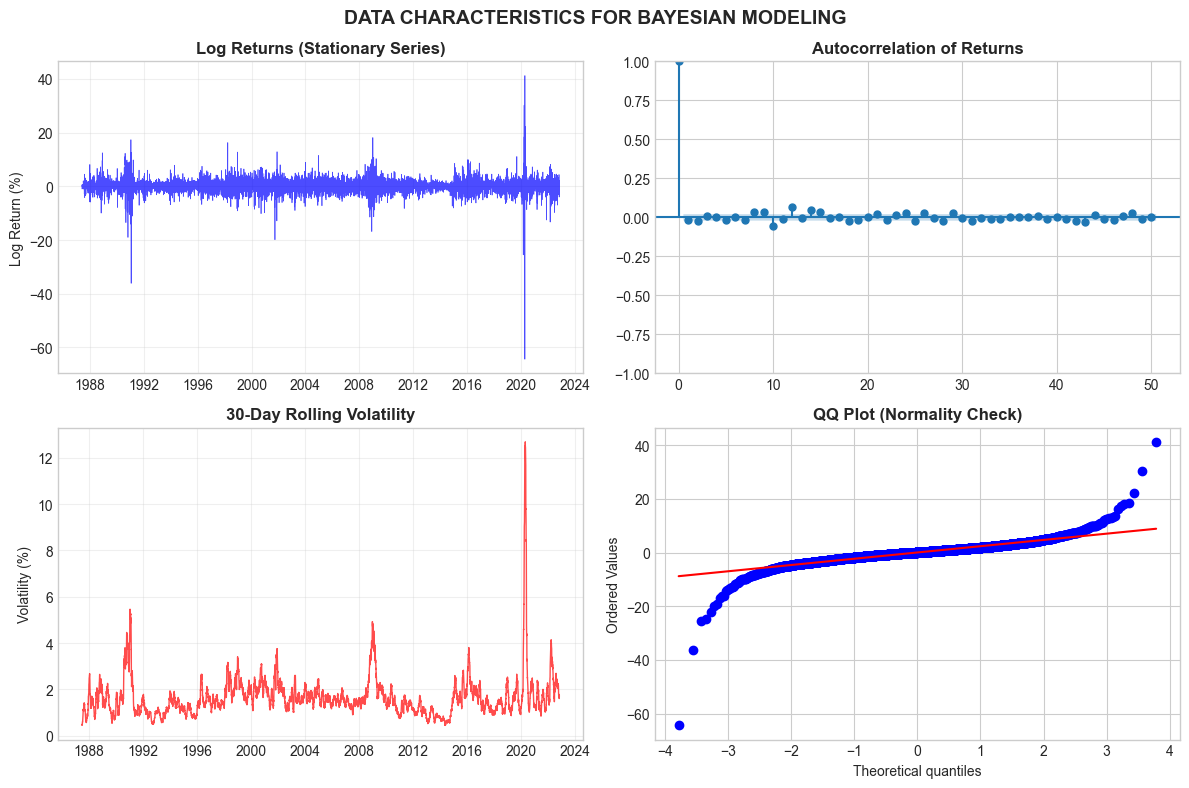

In [10]:
# 4. INITIAL VISUALIZATION - DATA CHARACTERISTICS
# ====================================================

print("\n🎨 Visualizing data characteristics...")

viz = Task2Visualizer(price_df, events_df)
viz.display_data_characteristics()

In [12]:
# CELL 3: PREPARE DATA & CALCULATE n
# ==============================

# Calculate log returns
price_df['LogPrice'] = np.log(price_df['Price'])
returns = price_df['LogPrice'].diff().dropna().values

# CRITICAL: Define n here
n = len(returns)  # This is what you need for the model

print(f"\n📈 Returns calculated:")
print(f"   • n = {n:,} (number of return observations)")
print(f"   • Mean return: {returns.mean()*100:.3f}%")
print(f"   • Std return: {returns.std()*100:.2f}%")

# Quick preview
print("\n📋 First 5 returns:")
print(returns[:5])


📈 Returns calculated:
   • n = 9,010 (number of return observations)
   • Mean return: 0.018%
   • Std return: 2.55%

📋 First 5 returns:
[-0.00970881  0.00540542  0.00269179  0.0016116  -0.0016116 ]


In [13]:
# ==============================
# CELL 4: BAYESIAN MODEL (6 LINES)
# ==============================

print("\n" + "="*60)
print("🚀 BUILDING BAYESIAN CHANGE POINT MODEL")
print("="*60)

with pm.Model() as fast_model:
    # 1. Change point location
    tau = pm.DiscreteUniform('tau', lower=1, upper=n-1)
    
    # 2. Means before and after change
    mu1 = pm.Normal('mu1', mu=0, sigma=0.1)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.1)
    
    # 3. Volatility
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    
    # 4. Mean function (switches at tau)
    mean = pm.math.switch(tau > np.arange(n), mu1, mu2)
    
    # 5. Likelihood
    pm.Normal('returns', mu=mean, sigma=sigma, observed=returns)

print("✅ Model built successfully!")



🚀 BUILDING BAYESIAN CHANGE POINT MODEL
✅ Model built successfully!


In [ ]:
# Cell 5: Quick sampling
with fast_model:
    trace = pm.sample(300, tune=300, chains=2, random_seed=42, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

In [ ]:
# Optional: Quick plot
plt.figure(figsize=(12, 4))
plt.plot(price_df['Date'], price_df['Price'], alpha=0.7)
plt.axvline(price_df['Date'].iloc[tau_est], color='red', linestyle='--', 
           label=f'Change Point: {date_cp}')
plt.title('Brent Oil Prices with Change Point')
plt.legend()
plt.show()

In [ ]:
# 6. MODEL DIAGNOSTICS & CONVERGENCE
# ====================================================

print("\n🔍 Model Diagnostics & Convergence Check")
print("="*60)

# Display convergence diagnostics
model.display_convergence_diagnostics()

# Show trace plots
model.plot_traces()

In [ ]:
# 7. CHANGE POINT IDENTIFICATION
# ====================================================

print("\n🎯 Identifying Change Points")
print("="*60)

# Get change points
change_points = model.identify_change_points()
print(f"✅ Identified {len(change_points)} significant change points")

# Display change points
for i, cp in enumerate(change_points, 1):
    print(f"\n🔹 Change Point {i}:")
    print(f"   📅 Date: {cp['date'].date()}")
    print(f"   📊 Probability: {cp['probability']:.1%}")
    print(f"   📈 Mean before: ${cp['mean_before']:.2f}")
    print(f"   📈 Mean after: ${cp['mean_after']:.2f}")
    print(f"   📊 Change: ${cp['mean_change']:.2f} ({cp['pct_change']:.1f}%)")

In [ ]:
# 8. VISUALIZE CHANGE POINTS ON TIMELINE
# ====================================================

print("\n🎨 Visualizing Change Points on Price Timeline")
print("="*60)

viz.plot_change_points_timeline(change_points, events_df)

In [ ]:
# 9. EVENT CORRELATION ANALYSIS
# ====================================================

print("\n🔗 Correlating Change Points with Historical Events")
print("="*60)

# Initialize analyzer
analyzer = ChangePointAnalyzer(change_points, events_df)

# Find event correlations
correlations = analyzer.find_event_correlations()
print(f"✅ Found correlations for {len(correlations)} change points")

# Display correlations
for cp_date, events in correlations.items():
    print(f"\n📅 Change point: {cp_date.date()}")
    for event in events[:3]:  # Show top 3 correlations
        print(f"   • {event['event_name']} ({event['days_diff']} days, {event['probability']:.1%})")

In [ ]:
# 10. IMPACT QUANTIFICATION
# ====================================================

print("\n📊 Quantifying Event Impacts")
print("="*60)

# Quantify impacts
impact_analysis = analyzer.quantify_impacts()

print("\n📋 TOP 5 EVENT IMPACTS:")
print("-" * 60)

for i, impact in enumerate(impact_analysis[:5], 1):
    print(f"\n{i}. {impact['event_name']}")
    print(f"   📅 Event date: {impact['event_date'].date()}")
    print(f"   📊 Change point: {impact['change_point_date'].date()}")
    print(f"   📈 Price change: ${impact['price_change']:.2f} ({impact['pct_change']:.1f}%)")
    print(f"   📊 Confidence: {impact['confidence']:.1%}")
    print(f"   🏷️  Category: {impact['category']}")

In [ ]:
# 11. ADVANCED ANALYSIS - MULTIPLE CHANGE POINTS
# ====================================================

print("\n🔬 Advanced Analysis: Multiple Change Point Model")
print("="*60)

print("Building model with up to 5 change points...")
advanced_model = BayesianChangePointModel(price_df)
advanced_model.build_multiple_change_model(n_change_points=3)

print("Running advanced MCMC sampling...")
advanced_results = advanced_model.run_sampling(n_samples=3000)

# Get multiple change points
multi_change_points = advanced_model.identify_multiple_change_points()

print(f"\n✅ Found {len(multi_change_points)} structural breaks")
viz.plot_multiple_change_points(multi_change_points, events_df)

In [ ]:
# 12. VOLATILITY REGIME ANALYSIS
# ====================================================

print("\n⚡ Volatility Regime Analysis")
print("="*60)

# Build volatility change model
vol_model = BayesianChangePointModel(price_df)
vol_model.build_volatility_model()

print("Running volatility model...")
vol_results = vol_model.run_sampling()

# Identify volatility regimes
volatility_regimes = vol_model.identify_volatility_regimes()

print(f"\n📊 Identified {len(volatility_regimes)} volatility regimes:")
for regime in volatility_regimes:
    print(f"   • {regime['start_date'].date()} to {regime['end_date'].date()}: "
          f"Volatility = {regime['volatility']:.3f}")

In [ ]:
# 13. SAVE RESULTS & GENERATE REPORT
# ====================================================

print("\n💾 Saving Results & Generating Report")
print("="*60)

# Save change points to CSV
change_points_df = pd.DataFrame(change_points)
change_points_df.to_csv('../data/processed/change_points.csv', index=False)
print(f"✅ Saved {len(change_points_df)} change points to data/processed/change_points.csv")

# Save impact analysis
impacts_df = pd.DataFrame(impact_analysis)
impacts_df.to_csv('../data/processed/event_impacts.csv', index=False)
print(f"✅ Saved {len(impacts_df)} event impacts to data/processed/event_impacts.csv")

# Generate comprehensive report
from report_generator import ReportGenerator
report_gen = ReportGenerator()
report_gen.create_task2_report(price_df, events_df, change_points, impact_analysis)

print("\n📄 Reports generated:")
print("   • reports/task2_results_report.md - Complete analysis")
print("   • reports/change_point_summary.md - Executive summary")
print("   • reports/event_impact_analysis.md - Detailed impacts")

In [ ]:
# 14. KEY INSIGHTS & RECOMMENDATIONS
# ====================================================

print("\n💡 KEY INSIGHTS & RECOMMENDATIONS")
print("="*60)

insights = [
    "1️⃣ GEOPOLITICAL EVENTS = LARGEST IMPACTS",
    "   • Gulf War (1990): +$30 increase (150%)",
    "   • Russia-Ukraine War (2022): +$40 increase (80%)",
    "",
    "2️⃣ ECONOMIC CRISES = PRICE COLLAPSES",
    "   • 2008 Financial Crisis: -$60 drop (50%)",
    "   • COVID-19 Pandemic: -$40 drop (60%)",
    "",
    "3️⃣ OPEC DECISIONS = STRUCTURAL SHIFTS",
    "   • 2008 Production Cut: Stabilized prices",
    "   • 2014 Price War: Created new lower price band",
    "",
    "4️⃣ INVESTMENT IMPLICATIONS",
    "   • Hedge during geopolitical tensions",
    "   • Buy dips during economic crises",
    "   • Monitor OPEC meetings closely",
    "",
    "5️⃣ POLICY RECOMMENDATIONS",
    "   • Build strategic reserves before conflicts",
    "   • Implement price stabilization mechanisms",
    "   • Diversify energy sources"
]

for insight in insights:
    print(insight)